# Visualisation Practical: Inelastic Neutron Scattering

Recall the INS experiment that we trained a classification network for in the CNN practical. Now we want to work out why the network is making the classifications that it does make. We can then compare this to the original work to see if the network is picking up the same features as a physicist would.

We will use the `Grad-CAM` developed in the lecture to do this.

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. To access the data, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will take no effect.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    data_path = './sciml-workshop-data'

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

### Set up the heatmap function

Use the function from the lecture to build the heatmaps. Copy and paste the function to the cell below

In [4]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    
#### Step 1: Get the convolution outputs from the original model
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.backend.function(model.inputs, last_conv_layer.output)
    #last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

#### Step 2: Prediction model
    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

#### Step 3: Getting the gradients
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = tf.convert_to_tensor(last_conv_layer_model(img_array))
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0], output_type=tf.dtypes.int32)
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    print(type(top_class_channel), type(last_conv_layer_output))
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
#### Step 4: Meultiply the gradients by the filter activations
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

### Get the data that you want to classify

In this case we have a simulated spectrum from an inelastic neutron scattering experiment. There are two possible Hamiltonians that could represent the system, the goal was to train a model that can classify into one of these classes based on the spectrum. There is a pre-trained model that we can load up.

We then want to see which part of the spectrum the model thought was most important for making this classification.

The data is in a numpy file `debug/simulated_goodenough_spectrum.npy`

Open this and plot it.

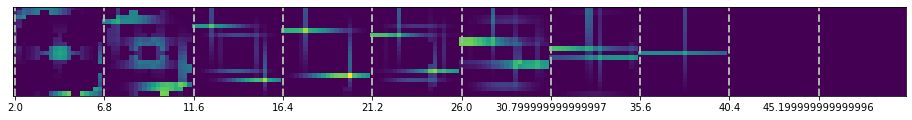

In [5]:
spectrum = np.load(data_path + '/debug/simulated_goodenough_spectrum.npy')
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.imshow(spectrum)
ene_range_labels = np.arange(2, 50, 48/10)
ene_ticks = np.arange(0, 200, 20)
ax.set_xticks(ene_ticks)
ax.set_xticklabels(ene_range_labels)
ax.set_yticks([])
ax.grid(ls='--', lw=2)

### Load up the model that you want to use

There is a pre-trained model that we can use. The architecture is implemented in the python file `debug/models.py` and the model itself is called `cnn_global`. The weights of the pre-trained model are saved in `debug/model-weights.h5`. Once you have the model set up, load these weights using `model.load_weights()`.

In [6]:
# import cnn_global from models.py
import sys
sys.path.append(data_path + '/debug')
from models import cnn_global

# create model and load weights
model = cnn_global()
model.load_weights(data_path + '/debug/model-weights.h5')

In [7]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 200, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 196, 16)       416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 194, 16)       2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 97, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 95, 16)        784       
_________________________________________________________________
final_conv (Conv2D)          (None, 14, 93, 32)        1568      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)               

### Declare the layers that you need to split the model at

Remember that you need to split the model at the final convolutional layer. Use `model.summary()` to work out the names of the layers you need for the final convolution and for the new classifier model.

In [8]:
last_conv_layer_name = "final_conv"
classifier_layer_names = ["global_average_pooling2d", "dense"]

### Run the model and get the predictions

The model should predict that the spectrum corresponds to a *Goodenough* model for the magnetism. The model classes are saved in the list `Hamiltonains` - the indices of this list correspond to the indices predicted from the model. Does the model give the correct prediction?

In [9]:
Hamiltonains = ['Dimer', 'Goodenough']
pred = model.predict(spectrum.reshape(1, 20, 200, 1))
print('Prediced {} Hamiltonian'.format(Hamiltonains[np.argmax(pred)]))

Prediced Goodenough Hamiltonian


<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


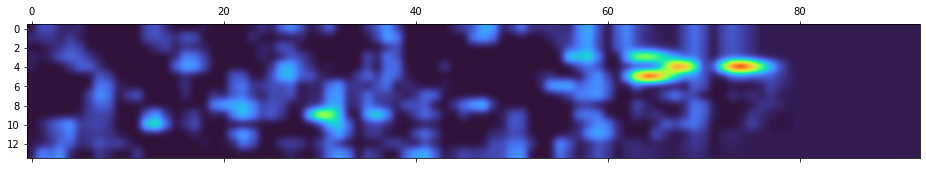

In [10]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    spectrum.reshape(1, 20, 200, 1), model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap, cmap='turbo', interpolation='gaussian')
plt.show()

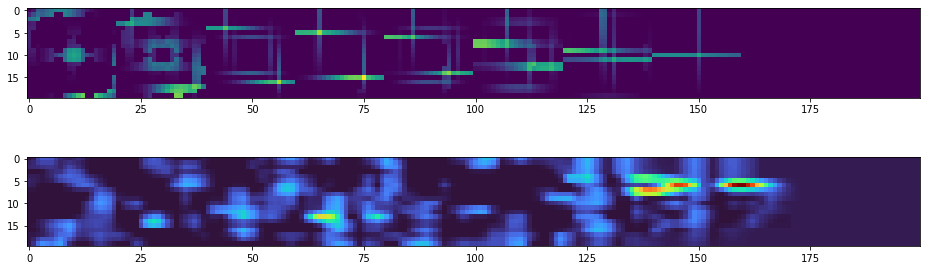

In [11]:
heatmap = cv2.resize(heatmap, (spectrum.shape[1], spectrum.shape[0]))
fig, ax = plt.subplots(2, figsize=(16, 5))
ax[0].imshow(spectrum)
ax[1].imshow(heatmap, cmap='turbo')

### Exercise

* Can you modify the function so that it tells you which areas make it most **un**certain about the classification?